In [1]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, RocCurveDisplay, auc, log_loss, recall_score, f1_score, precision_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


# Persiapan data

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Data Science/1. Telco Customer Churn/Data/TelcoChurn_prep.csv")

In [6]:
df = df.drop(["customerID"],axis=1)

In [7]:
df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

In [8]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [9]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sm, y_train_sm)

In [10]:
selector = SelectKBest(score_func=f_classif, k=10)
X_train_res_sel = selector.fit_transform(X_train_res, y_train_res)
X_test_sel = selector.transform(X_test_sm)

In [11]:
selected_features = selector.get_feature_names_out(input_features=X.columns)

X_train_res_sel_df = pd.DataFrame(X_train_res_sel, columns=selected_features)
X_test_sel_df = pd.DataFrame(X_test_sel, columns=selected_features)

In [12]:
pca = PCA(n_components=5)
X_train_res_pca = pca.fit_transform(X_train_res_sel)
X_test_pca = pca.transform(X_test_sel)

In [13]:
X_train_res_pca_df = pd.DataFrame(X_train_res_pca, columns=[f'PC{i+1}' for i in range(X_train_res_pca.shape[1])])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Final Model

In [14]:
dt = DecisionTreeClassifier(random_state=42, max_depth= 3, min_samples_leaf= 10, min_samples_split= 15)

In [15]:
dt.fit(X_train_res_pca_df, y_train_res)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=15,
                       random_state=42)

In [16]:
y_pred = dt.predict(X_test_pca_df)

In [18]:
print("Accuracy:", accuracy_score(y_test_sm, y_pred))
print("Precision:", precision_score(y_test_sm, y_pred))
print("Recall:", recall_score(y_test_sm, y_pred))
print("F1-score:", f1_score(y_test_sm, y_pred))
print("Confusion matriks: \n",confusion_matrix(y_test_sm, y_pred))
print(classification_report(y_test_sm, y_pred))

Accuracy: 0.6800947867298578
Precision: 0.44550669216061184
Recall: 0.8306595365418895
F1-score: 0.5799626633478532
Confusion matriks: 
 [[969 580]
 [ 95 466]]
              precision    recall  f1-score   support

           0       0.91      0.63      0.74      1549
           1       0.45      0.83      0.58       561

    accuracy                           0.68      2110
   macro avg       0.68      0.73      0.66      2110
weighted avg       0.79      0.68      0.70      2110



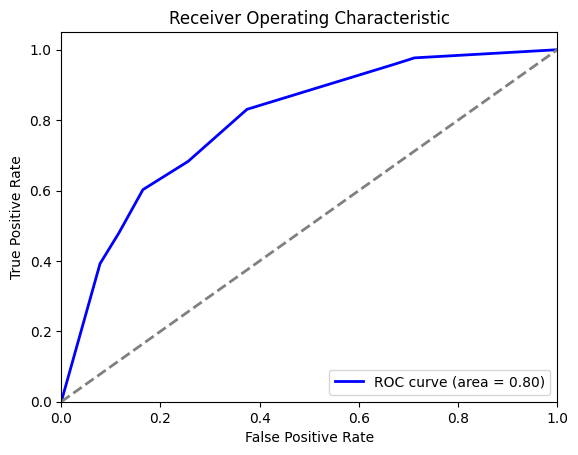

In [19]:
y_pred_proba = dt.predict_proba(X_test_pca_df)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_sm, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

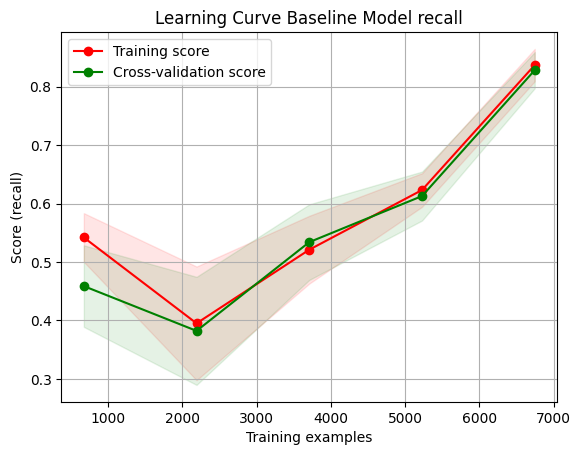

In [20]:
cv = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(dt, X_train_res_pca_df, y_train_res, cv=cv, scoring='recall')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve Baseline Model recall")
plt.xlabel("Training examples")
plt.ylabel("Score (recall)")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()